In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy

# Orange Trees: Non-linear growth curve

In [37]:
data = {'x' : [118, 484, 664, 1004, 1231, 1372, 1582], #Instants de mesure
        'Y' : [[30, 58, 87, 115, 120, 142, 145], [33, 69, 111, 156, 172, 203, 203], #Pour chacun des 5 arbres, on a les circonférences mesurées aux 7 instants x
            [30, 51, 75, 108, 115, 139, 140], [32, 62, 112, 167, 179, 209, 214],
            [30, 49, 81, 125, 142, 174, 177]]
        }         

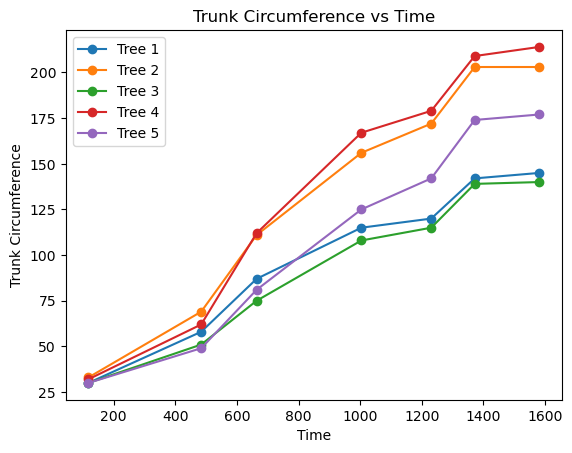

In [36]:
#Affichons l'évolution de la circonférence pour chaque arbre
for i in range(len(data['Y'])):
    plt.plot(data['x'], data['Y'][i], '-o', label='Tree '+str(i+1))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Trunk Circumference')
plt.title('Trunk Circumference vs Time')
plt.show()

In [45]:
def MH_within_Gibbs_Orange_Trees(nchain, data, priors_tau_c, priors_theta_1, priors_theta_2, priors_theta_3, init_chain_theta, init_chain_tau, prop_sd_theta, prop_sd_tau_c):
    # priors_theta_1 : matrice 5 x 2 (couple (mu, sigma) pour chaque arbre)
    # priors_theta_2 : matrice 5 x 2 (couple (mu, sigma) pour chaque arbre)
    # priors_theta_3 : matrice 5 x 2 (couple (mu, sigma) pour chaque arbre)
    # priors_tau_c : matrice 1 x 2 (couple (alpha, beta))
    # init_chain_theta : matrice 3 x 5 (les 3 valeurs initiales pour chaque arbre)

    #On a 16 chaines à générer : 5 pour les theta_i_1, 5 pour theta_i_2, 5 pour theta_i_3 et 1 pour tau_c
    chain_theta_1 = np.zeros((nchain, 5))
    chain_theta_2 = np.zeros((nchain, 5)) 
    chain_theta_3 = np.zeros((nchain, 5))
    chain_tau = np.zeros((nchain, 1)) 
    
    #Initialisations des 16 chaines
    chain_theta_1[0] = init_chain_theta[0]
    chain_theta_2[0] = init_chain_theta[1] 
    chain_theta_3[0] = init_chain_theta[2]
    chain_tau[0] = init_chain_tau

    x = np.array(data['x']) #Instants de mesure
    I = len(data['Y']) #Nombre d'arbres
    J = len(data['Y'][0]) #Nombre d'instants de mesure    

    
    for t in range(1, nchain+1) :
        chain_theta_1[t] = chain_theta_1[t-1]
        chain_theta_2[t] = chain_theta_2[t-1]
        chain_theta_3[t] = chain_theta_3[t-1]
        current_tau_c = chain_tau[t-1]


        #Fonction utilisée après pour mettre à jour eta_i_j
        def update_eta(current_theta_1, current_theta_2, current_theta_3):
            phi_1 = np.exp(current_theta_1)[:, np.newaxis] 
            phi_2 = (np.exp(current_theta_2) - 1)[:, np.newaxis] 
            phi_3 = (-np.exp(current_theta_3))[:, np.newaxis] 
            x_reshaped = x[np.newaxis, :] #On rajoute une dimension aux instants de mesure pour que la vectorisation fonctionne bien
            eta_values = phi_1 / (1 + phi_2 * np.exp(phi_3 * x_reshaped)) 

            return eta_values
        
        #Fonction utilisée après pour évaluer la distribution cible
        def target_distribution(value, i, k): #k = 1 pour theta_i_1, 2 pour theta_i_2, 3 pour theta_i_3@
            if k == 1:
                priors_theta = priors_theta_1
            elif k == 2:
                priors_theta = priors_theta_2
            else:
                priors_theta = priors_theta_3
            
            eta = update_eta(chain_theta_1[t], chain_theta_2[t], chain_theta_3[t]) #On recalcule eta avant chaque mise à jour de chaine pour s'assurer qu'il soit bien à jour
            likelihood = np.exp(-np.sum((data['Y'][i]-eta[i]))/2*current_tau_c)
            prior = np.exp(-(value-priors_theta[i][0])/(2*priors_theta[i][1]))
            return (likelihood * prior)
 


        #Successivement, pour chaque chaine, on va générer un candidat grâce à une marche aléatoire gaussienne, puis on va l'accepter ou le rejeter (puisqu'on ne sait pas identifier les distributions à postériori des theta_i_k à cause de la non-linéarité du modèle)

        #Mises à jour chaines 1 à 5 : theta_i_1
        for i in range(I) :
            candidat = np.random.normal(loc = chain_theta_1[t][i], scale = prop_sd_theta) 
            alpha = target_distribution(candidat, i, 1) / target_distribution(chain_theta_1[t-1][i], i, 1)
            u = np.random.uniform()
            if u < alpha : 
                chain_theta_1[t][i] = candidat

        #Mises à jour chaines 6 à 10 : theta_i_2
        for i in range(I) :
            candidat = np.random.normal(loc = chain_theta_2[t][i], scale = prop_sd_theta) 
            alpha = target_distribution(candidat, i, 2) / target_distribution(chain_theta_2[t-1][i], i, 2)
            u = np.random.uniform()
            if u < alpha : 
                chain_theta_2[t][i] = candidat

        #Mises à jour chaines 11 à 15 : theta_i_3
        for i in range(I) :
            candidat = np.random.normal(loc = chain_theta_3[t][i], scale = prop_sd_theta) 
            alpha = target_distribution(candidat, i, 3) / target_distribution(chain_theta_3[t-1][i], i, 3)
            u = np.random.uniform()
            if u < alpha : 
                chain_theta_3[t][i] = candidat

        # Mise à jour chaine 16 : tau_c (Pour tau_c on connait la distribution a posteriori, donc on peut directement générer la prochaine valeur à partir de cette distribution sans passer par le calcul de alpha etc)
        eta = update_eta(chain_theta_1[t], chain_theta_2[t], chain_theta_3[t])
        alpha = priors_tau_c[0] + J*I/2
        beta = priors_tau_c[1] + 0.5*np.sum((data-eta)**2)
        current_tau_c = stats.gamma(alpha,beta)

    return chain_theta_1, chain_theta_2, chain_theta_3, chain_tau

In [ ]:
#Données d'initialisation (seront utiles pour l'éxécution de l'algorithme)
#theta <- structure(c(5, 5, 5, 5, 5,
#                2, 2, 2, 2, 2,
#		-6, -6, -6, -6, -6), 
#      .Dim = c(5, 3))
#mu <- c(5, 2, -6)
#tau <- c(20, 20, 20)
#tau_C <- 20